In [1]:
# 自定义数据集
# 1.构造torch自定义dataset
# 2.数据增强
# 3.dataloader加载
# 4.测试一组数据

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import glob

C:\conda\envs\unet_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 构造自定义torch dataset：https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [4]:
from torch.utils.data import Dataset, DataLoader

In [5]:
class SegmentDataset(Dataset):

    def __init__(self,where='train'):
        # 获取数据
        self.img_list = glob.glob('processed/{}/*/img_*'.format(where))
        # self.mask_list = glob.glob('processed/{}/*/img_*')

    def __len__(self):
        # 返回数据大小
        return len(self.img_list)

    def __getitem__(self, idx):
        # 获取具体每一个数据
        
        # 获取图片
        img_file = self.img_list[idx]
        mask_file = img_file.replace('img','label')
        img = np.load(img_file)
        # 获取mask
        mask = np.load(mask_file)
        
        # 灰度图扩张维度成张量
        return np.expand_dims(img,0) , np.expand_dims(mask,0)
        

In [6]:
# 测试获取一张图

In [7]:
dataset = SegmentDataset('train')

In [8]:
len(dataset)

3343

In [9]:
# 随机显示16张图

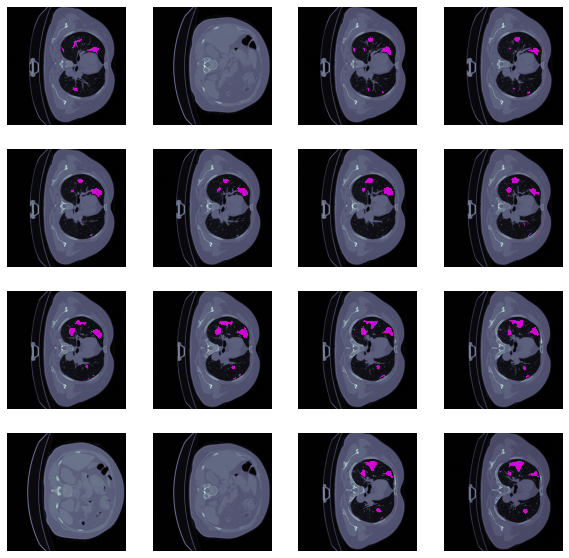

In [10]:
fig = plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    img , mask = dataset[i+100]
    plt.imshow(img[0], cmap='bone')
    mask_ = np.ma.masked_where(mask[0]== 0, mask[0])
    plt.imshow(mask_, alpha=0.8, cmap="spring")
    
    plt.axis('off')
plt.show()

In [11]:
# 数据增强 https://imgaug.readthedocs.io/en/latest/source/examples_segmentation_maps.html

In [12]:
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [13]:
class SegmentDataset(Dataset):

    def __init__(self,where='train',seq=None):
        # 获取数据
        self.img_list = glob.glob('processed/{}/*/img_*'.format(where))
        # self.mask_list = glob.glob('processed/{}/*/img_*')
        # 数据增强pipeline
        self.seq = seq

    def __len__(self):
        # 返回数据大小
        return len(self.img_list)
    

    def __getitem__(self, idx):
        # 获取具体每一个数据
        
        # 获取图片
        img_file = self.img_list[idx]
        mask_file = img_file.replace('img','label')
        img = np.load(img_file)
        # 获取mask
        mask = np.load(mask_file)
        
        # 如果需要数据增强
        if self.seq:
            segmap = SegmentationMapsOnImage(mask, shape=mask.shape)
            img,mask = seq(image=img, segmentation_maps=segmap)
            # 直接获取数组内容
            mask =  mask.get_arr()
        
        # 灰度图扩张维度成张量
        return np.expand_dims(img,0) , np.expand_dims(mask,0)
        

In [14]:
# 数据增强处理流程
seq = iaa.Sequential([
    iaa.Affine(scale=(0.8, 1.2), # 缩放
               rotate=(-45, 45)),  # 旋转
    iaa.ElasticTransformation()  # 变换
                ])

In [15]:
dataset = SegmentDataset('train',seq)

In [16]:
len(dataset)

3343

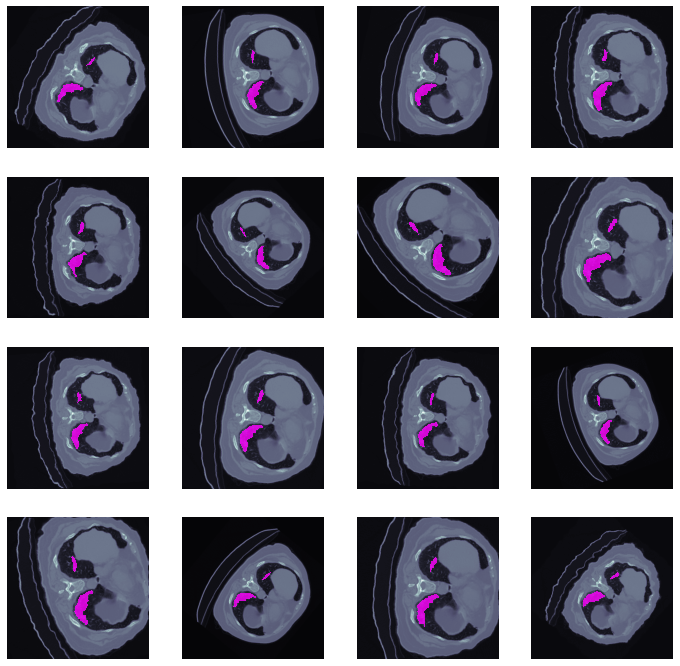

In [17]:
# 对同一个图片显示多次
fig = plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    img , mask = dataset[300]
    plt.imshow(img[0], cmap='bone')
    mask_ = np.ma.masked_where(mask[0]== 0, mask[0])
    plt.imshow(mask_, alpha=0.8, cmap="spring")
    
    plt.axis('off')
plt.show()

In [18]:
# 使用dataloader加载
batch_size = 16
num_workers = 0

train_dataset = SegmentDataset('train',seq)
test_dataset = SegmentDataset('test',None)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)


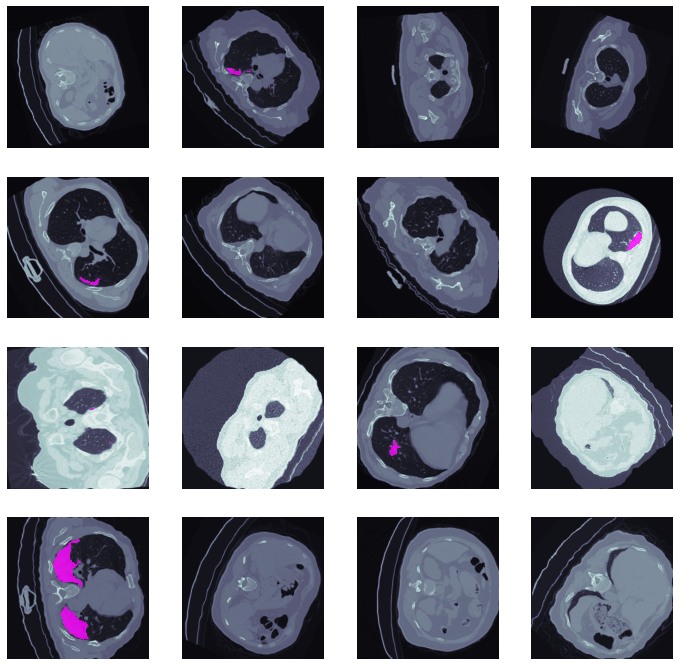

In [19]:
# 显示几张
for x in train_loader:
    # 设置画布大小
    fig = plt.figure(figsize=(12, 12))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        img , mask = x[0][i],x[1][i]
        plt.imshow(img[0], cmap='bone')
        mask_ = np.ma.masked_where(mask[0]== 0, mask[0])
        plt.imshow(mask_, alpha=0.8, cmap="spring")

        plt.axis('off')
    plt.show()
    break